In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.utils.np_utils import to_categorical

In [3]:
# download nltk stopwords
stop_words = stopwords.words('english')

### Read Data

In [7]:
train = pd.read_csv("data/stack overflow/train.csv")
valid = pd.read_csv("data/stack overflow/valid.csv")

In [8]:
train.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [9]:
train.shape

(45000, 6)

In [10]:
valid.shape

(15000, 6)

### Traditional Machine Learning Approaches

#### Process Text

In [11]:
def clean_text(data):
    data = data.lower()
    data = re.sub(r'[^(a-zA-Z)\s]','',data)
    data = data.split()
    temp = []
    for i in data:
        if i not in stop_words:
            temp.append(i)
    data = ' '.join(temp)
    return data

In [12]:
text_df = train.append(valid)

In [13]:
text_df['Y'] = text_df['Y'].map({'LQ_CLOSE':0,'LQ_EDIT':1,'HQ':2})

In [14]:
text_df['X'] = text_df.Title+ ' ' +text_df.Body

In [15]:
text_df['X'] = text_df['X'].apply(clean_text)

#### Split into training, validation, and test data

In [145]:
X_train, X_test, Y_train, Y_test = train_test_split(text_df['X'].tolist(), text_df['Y'].tolist(), test_size=.2, random_state=21)

In [146]:
X_val, X_train, Y_val, Y_train = train_test_split(X_train, Y_train, test_size=.5, random_state=21)

In [147]:
vectorizer = CountVectorizer(binary=True, max_features=10000)

In [148]:
X_train = vectorizer.fit_transform(X_train).toarray()
X_val = vectorizer.transform(X_val).toarray()
X_test = vectorizer.transform(X_test).toarray()

#### XGBoost

In [149]:
from xgboost import XGBClassifier

In [150]:
xgb = XGBClassifier()
xgb.fit(X_train,Y_train)

C:\Users\jcard\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:25:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [151]:
predictions = xgb.predict(X_test)

In [152]:
accuracy_score(predictions,Y_test)

0.87525

#### Random Forest

In [153]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
clf = RandomForestClassifier(random_state=0)

In [155]:
clf.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In [156]:
y_pred = clf.predict(X_test)

In [157]:
from sklearn.metrics import accuracy_score

In [158]:
accuracy_score(Y_test, y_pred)

0.8613333333333333

#### Logistic Regression

In [159]:
from sklearn.linear_model import LogisticRegression

In [160]:
logreg = LogisticRegression(random_state=0, max_iter=1000)

In [161]:
logreg.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [162]:
y_pred = logreg.predict(X_test)

In [163]:
accuracy_score(Y_test, y_pred)

0.8733333333333333

#### Prep data for neural net

In [164]:
Y_train_nn = to_categorical(Y_train)
Y_val_nn = to_categorical(Y_val)
Y_test_nn = to_categorical(Y_test)

### Define Feedforward NN

In [241]:
from numpy.random import seed
seed(1)

In [242]:
# define feed forward NN
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(3, activation='softmax'))

In [243]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [244]:
history = model.fit(X_train,
                    Y_train_nn,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_val, Y_val_nn))

Epoch 1/20
188/188 [==============================] - 3s 12ms/step - loss: 0.8256 - acc: 0.7064 - val_loss: 0.4507 - val_acc: 0.8635
Epoch 2/20
188/188 [==============================] - 2s 11ms/step - loss: 0.3712 - acc: 0.8967 - val_loss: 0.3246 - val_acc: 0.8900
Epoch 3/20
188/188 [==============================] - 2s 12ms/step - loss: 0.2468 - acc: 0.9241 - val_loss: 0.2863 - val_acc: 0.8940
Epoch 4/20
188/188 [==============================] - 2s 12ms/step - loss: 0.1949 - acc: 0.9330 - val_loss: 0.2778 - val_acc: 0.8947
Epoch 5/20
188/188 [==============================] - 2s 12ms/step - loss: 0.1672 - acc: 0.9424 - val_loss: 0.2758 - val_acc: 0.8963
Epoch 6/20
188/188 [==============================] - 2s 12ms/step - loss: 0.1490 - acc: 0.9487 - val_loss: 0.2815 - val_acc: 0.8962
Epoch 7/20
188/188 [==============================] - 2s 11ms/step - loss: 0.1308 - acc: 0.9545 - val_loss: 0.2881 - val_acc: 0.8953
Epoch 8/20
188/188 [==============================] - 2s 12ms/step - 

### Plot training vs validation loss

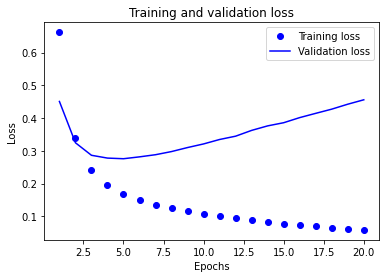

In [245]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['acc']) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot trainings vs validation accuracy

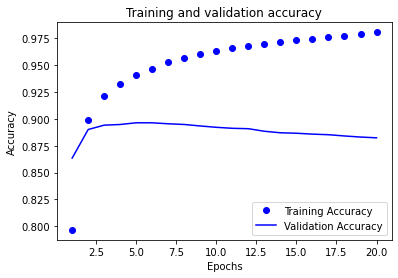

In [246]:
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Train model using 5 epochs
Validation loss was minimized and validation accuracy was maximized around 5 epochs

In [247]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.fit(X_train, Y_train_nn, epochs=3, batch_size=128)

Epoch 1/3
188/188 [==============================] - 2s 7ms/step - loss: 0.8629 - acc: 0.6760
Epoch 2/3
188/188 [==============================] - 1s 7ms/step - loss: 0.3932 - acc: 0.8928
Epoch 3/3
188/188 [==============================] - 1s 7ms/step - loss: 0.2559 - acc: 0.9205


In [248]:
# evaluate model
results = model.evaluate(X_test, Y_test_nn)

375/375 [==============================] - 1s 2ms/step - loss: 0.2993 - acc: 0.8873


In [191]:
y_pred = model.predict(X_test)